In [81]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import requests
from tqdm.auto import tqdm
tqdm.pandas()

In [4]:
def next_monday(date):
    return pd.date_range(start=date, end=date + pd.offsets.Day(6), freq='W-MON')[0]

# Setting

In [5]:
test_date = pd.to_datetime('2021-05-03')

In [38]:
test_date = pd.to_datetime('2021-04-26')

In [39]:
models_to_exclude = ['COVIDhub-ensemble', 'COVIDhub-trained_ensemble', 
                     'CU-nochange', 'CU-scenario_high', 'CU-scenario_low', 'CU-scenario_mid']

locations_to_exclude = ["60", "66", "69", "72", "74", "78"]

# DC,11,District of Columbia
# AS,60,American Samoa
# GU,66,Guam
# MP,69,Northern Mariana Islands
# PR,72,Puerto Rico
# UM,74,U.S. Minor Outlying Islands
# VI,78,Virgin Islands

In [40]:
dtype={'target': str, 'location': str, 'type': str, 'quantile': float, 'value': float}
parse_dates=['forecast_date', 'target_end_date']

# Load Files

In [41]:
url = "https://api.github.com/repos/reichlab/covid19-forecast-hub/git/trees/master?recursive=1"
r = requests.get(url)
res = r.json()

In [42]:
files = [file["path"] for file in res["tree"] if (file["path"].startswith('data-processed/') and file["path"].endswith('.csv'))]

In [43]:
files[-5:]

['data-processed/epiforecasts-ensemble1/2021-04-05-epiforecasts-ensemble1.csv',
 'data-processed/epiforecasts-ensemble1/2021-04-12-epiforecasts-ensemble1.csv',
 'data-processed/epiforecasts-ensemble1/2021-04-19-epiforecasts-ensemble1.csv',
 'data-processed/epiforecasts-ensemble1/2021-04-26-epiforecasts-ensemble1.csv',
 'data-processed/epiforecasts-ensemble1/2021-05-03-epiforecasts-ensemble1.csv']

In [113]:
df_files = pd.DataFrame({'filename':files})

df_files['model'] = df_files.filename.apply(lambda f: f.split('/')[1])

df_files['forecast_date'] = df_files.filename.apply(lambda f: f.split('/')[2][:10])
df_files.forecast_date = pd.to_datetime(df_files.forecast_date)

df_files['timezero'] = df_files.forecast_date.apply(next_monday)

In [114]:
# df_files = df_files[~df_files.model.isin(models_to_exclude)]

In [115]:
df_files

,filename,model,forecast_date,timezero
0,data-processed/AIpert-pwllnod/2020-12-21-AIper...,AIpert-pwllnod,2020-12-21,2020-12-21
1,data-processed/AIpert-pwllnod/2020-12-28-AIper...,AIpert-pwllnod,2020-12-28,2020-12-28
2,data-processed/AIpert-pwllnod/2021-01-04-AIper...,AIpert-pwllnod,2021-01-04,2021-01-04
3,data-processed/AIpert-pwllnod/2021-01-11-AIper...,AIpert-pwllnod,2021-01-11,2021-01-11
4,data-processed/AIpert-pwllnod/2021-01-18-AIper...,AIpert-pwllnod,2021-01-18,2021-01-18
...,...,...,...,...
3303,data-processed/epiforecasts-ensemble1/2021-04-...,epiforecasts-ensemble1,2021-04-05,2021-04-05
3304,data-processed/epiforecasts-ensemble1/2021-04-...,epiforecasts-ensemble1,2021-04-12,2021-04-12
3305,data-processed/epiforecasts-ensemble1/2021-04-...,epiforecasts-ensemble1,2021-04-19,2021-04-19
3306,data-processed/epiforecasts-ensemble1/2021-04-...,epiforecasts-ensemble1,2021-04-26,2021-04-26


### Test Data

In [116]:
VALID_TARGETS = [f"{_} wk ahead inc death" for _ in range(1, 5)] + \
                [f"{_} wk ahead cum death" for _ in range(1, 5)] + \
                [f"{_} wk ahead inc case" for _ in range(1, 5)]

In [117]:
df_test_files = df_files[df_files.timezero == test_date]

In [118]:
df_test_files.head()

,filename,model,forecast_date,timezero
18,data-processed/AIpert-pwllnod/2021-04-26-AIper...,AIpert-pwllnod,2021-04-26,2021-04-26
61,data-processed/BPagano-RtDriven/2021-04-25-BPa...,BPagano-RtDriven,2021-04-25,2021-04-26
107,data-processed/CEID-Walk/2021-04-26-CEID-Walk.csv,CEID-Walk,2021-04-26,2021-04-26
149,data-processed/CMU-TimeSeries/2021-04-26-CMU-T...,CMU-TimeSeries,2021-04-26,2021-04-26
206,data-processed/COVIDhub-baseline/2021-04-26-CO...,COVIDhub-baseline,2021-04-26,2021-04-26


In [119]:
dfs_test = []

for _, row in tqdm(df_test_files.iterrows(), total=df_test_files.shape[0]):
    #print(row['filename'])
    df_temp = pd.read_csv('https://github.com/reichlab/covid19-forecast-hub/raw/master/' + row['filename'],
                         dtype=dtype, parse_dates=parse_dates)
    df_temp = df_temp[df_temp.target.isin(VALID_TARGETS)]
    df_temp['model'] = row['model']
    dfs_test.append(df_temp)

  0%|          | 0/66 [00:00<?, ?it/s]

In [120]:
df_test = pd.concat(dfs_test)

In [121]:
df_test.shape

(2986725, 8)

In [122]:
# only consider US + 50 states
df_test = df_test[df_test.location.str.len() == 2]
df_test = df_test[~df_test.location.isin(locations_to_exclude)]

In [123]:
df_test.shape

(461604, 8)

In [124]:
df_test.location.nunique()

52

In [23]:
# ensure that for all targets each model provides forecasts for all locations
df_test = df_test[df_test.groupby(['target', 'model'])['location'].transform('nunique') == 52]

In [125]:
df_test = df_test[df_test.type == 'quantile']

In [126]:
df_test['no_quantiles'] = df_test.groupby(['model', 'target', 'target_end_date', 'location'])['quantile'].transform('nunique')

df_test['no_quantiles'] = df_test.groupby(['target', 'model'])['no_quantiles'].transform('min')

In [127]:
df_test = df_test[(df_test.no_quantiles == 23) | 
        (df_test.target.str.contains('inc case') & (df_test.no_quantiles == 7))].drop(columns='no_quantiles').reset_index(drop=True)

In [128]:
df_test.shape

(433564, 8)

In [129]:
# dict of the models available for each target
available_models = dict(df_test.groupby(['target'])['model'].unique())

In [130]:
available_models

{'1 wk ahead cum death': array(['BPagano-RtDriven', 'CEID-Walk', 'COVIDhub-baseline',
        'COVIDhub-ensemble', 'CU-nochange', 'CU-scenario_high',
        'CU-scenario_low', 'CU-scenario_mid', 'CU-select',
        'Columbia_UNC-SurvCon', 'Covid19Sim-Simulator',
        'CovidAnalytics-DELPHI', 'DDS-NBDS', 'FDANIHASU-Sweight',
        'GT-DeepCOVID', 'Google_Harvard-CPF', 'IHME-CurveFit',
        'IUPUI-HkPrMobiDyR', 'IowaStateLW-STEM', 'JHUAPL-Bucky',
        'JHU_CSSE-DECOM', 'JHU_IDD-CovidSP',
        'KITmetricslab-select_ensemble', 'Karlen-pypm', 'LANL-GrowthRate',
        'LNQ-ens1', 'MIT_CritData-GBCF', 'MOBS-GLEAM_COVID',
        'Microsoft-DeepSTIA', 'OliverWyman-Navigator', 'PSI-DRAFT',
        'RobertWalraven-ESG', 'SteveMcConnell-CovidComplete',
        'UA-EpiCovDA', 'UCM_MESALab-FoGSEIR', 'UCSD_NEU-DeepGLEAM',
        'UMass-MechBayes', 'UMich-RidgeTfReg', 'USC-SI_kJalpha',
        'UT-Mobility', 'epiforecasts-ensemble1'], dtype=object),
 '1 wk ahead inc case': array(['

# Scoring

In [131]:
def add_truth(df, target = 'cumulative_deaths'):
    as_of = max(df.target_end_date) + pd.Timedelta('2 days')
    as_of = str(as_of.date())
    
    truth = pd.read_csv('data/JHU/' + target + '/truth_jhu_' + target + '_' + as_of + '.csv', parse_dates=['date'])
    truth.rename(columns={'value': 'truth'}, inplace=True)
    
    df = df.merge(truth, left_on=['target_end_date', 'location'], right_on=['date', 'location'], how='left')
    
    return(df)

In [132]:
def wis(df):
    qs = df['quantile'].unique()
    qs.sort()
    
    df_temp = df.pivot(index=df.columns.drop(['quantile', 'value']), 
                   columns='quantile', values='value').add_prefix('value_').reset_index()
    df_temp.columns.name = None
    
    for i, l in enumerate(qs[qs < 0.5]):
        u = qs[-(i+1)]
        coverage = np.round(u - l, 2)

        df_temp['wgt_iw_' + str(coverage)] = (1 - coverage)/2 * (df_temp['value_' + str(u)] - df_temp['value_' + str(l)])

        df_temp['wgt_pen_u_' + str(coverage)] = (df_temp.truth - df_temp['value_' + str(u)]).clip(lower=0)
        df_temp['wgt_pen_l_' + str(coverage)] = (df_temp['value_' + str(l)] - df_temp.truth).clip(lower=0)
    
    df_temp['wgt_pen_u_0'] = (df_temp.truth - df_temp['value_0.5']).clip(lower=0)/2
    df_temp['wgt_pen_l_0'] = (df_temp['value_0.5'] - df_temp.truth).clip(lower=0)/2

    df_temp['wgt_iw'] = df_temp.loc[:, df_temp.columns.str.contains('wgt_iw')].sum(axis=1)/(len(qs)/2)
    df_temp['wgt_pen_u'] = df_temp.loc[:, df_temp.columns.str.contains('wgt_pen_u')].sum(axis=1)/(len(qs)/2)
    df_temp['wgt_pen_l'] = df_temp.loc[:, df_temp.columns.str.contains('wgt_pen_l')].sum(axis=1)/(len(qs)/2)
    df_temp['wis'] = df_temp.wgt_iw + df_temp.wgt_pen_u + df_temp.wgt_pen_l
    
    df_temp = df_temp.loc[:, [not s[-1].isdigit() for s in df_temp.columns]]
    
    return df_temp

In [133]:
df_temp = df_test[df_test.target == '1 wk ahead inc death']

In [134]:
df_temp

,forecast_date,target,target_end_date,quantile,type,value,location,model
0,2021-04-25,1 wk ahead inc death,2021-05-01,0.010,quantile,2937.19686,US,BPagano-RtDriven
1,2021-04-25,1 wk ahead inc death,2021-05-01,0.025,quantile,3230.03652,US,BPagano-RtDriven
2,2021-04-25,1 wk ahead inc death,2021-05-01,0.050,quantile,3491.81974,US,BPagano-RtDriven
3,2021-04-25,1 wk ahead inc death,2021-05-01,0.100,quantile,3798.35931,US,BPagano-RtDriven
4,2021-04-25,1 wk ahead inc death,2021-05-01,0.150,quantile,4006.52674,US,BPagano-RtDriven
...,...,...,...,...,...,...,...,...
433398,2021-04-26,1 wk ahead inc death,2021-05-01,0.850,quantile,4935.00000,US,epiforecasts-ensemble1
433399,2021-04-26,1 wk ahead inc death,2021-05-01,0.900,quantile,5039.00000,US,epiforecasts-ensemble1
433400,2021-04-26,1 wk ahead inc death,2021-05-01,0.950,quantile,5143.00000,US,epiforecasts-ensemble1
433401,2021-04-26,1 wk ahead inc death,2021-05-01,0.975,quantile,5214.00000,US,epiforecasts-ensemble1


In [135]:
df_temp = add_truth(df_temp, 'incident_deaths')

In [136]:
scores = wis(df_temp)

In [148]:
scores[scores.location != 'US'].groupby('model')['wis'].mean()

model
BPagano-RtDriven                 11.528021
CEID-Walk                        12.213008
CMU-TimeSeries                    9.274279
COVIDhub-baseline                13.629028
COVIDhub-ensemble                 9.190417
CU-nochange                      11.448483
CU-scenario_high                 11.448638
CU-scenario_low                  11.365834
CU-scenario_mid                  11.449614
CU-select                        11.449614
Columbia_UNC-SurvCon             16.213940
Covid19Sim-Simulator             10.813268
CovidAnalytics-DELPHI            18.136131
DDS-NBDS                         14.977304
GT-DeepCOVID                     11.871795
IEM_MED-CovidProject             12.980211
IHME-CurveFit                    14.721616
IUPUI-HkPrMobiDyR                10.599326
IowaStateLW-STEM                 13.501857
JHUAPL-Bucky                     19.807695
JHU_CSSE-DECOM                    9.712951
JHU_IDD-CovidSP                  22.959841
KITmetricslab-select_ensemble    10.399002
Karle

In [91]:
scores = scores.groupby('model').filter(lambda x: x.wis.mean() <= 100)

TypeError: filter function returned a Series, but expected a scalar bool

In [138]:
scores = scores.groupby(['model', 'location']).filter(lambda x: x.wis.mean() <= 100)

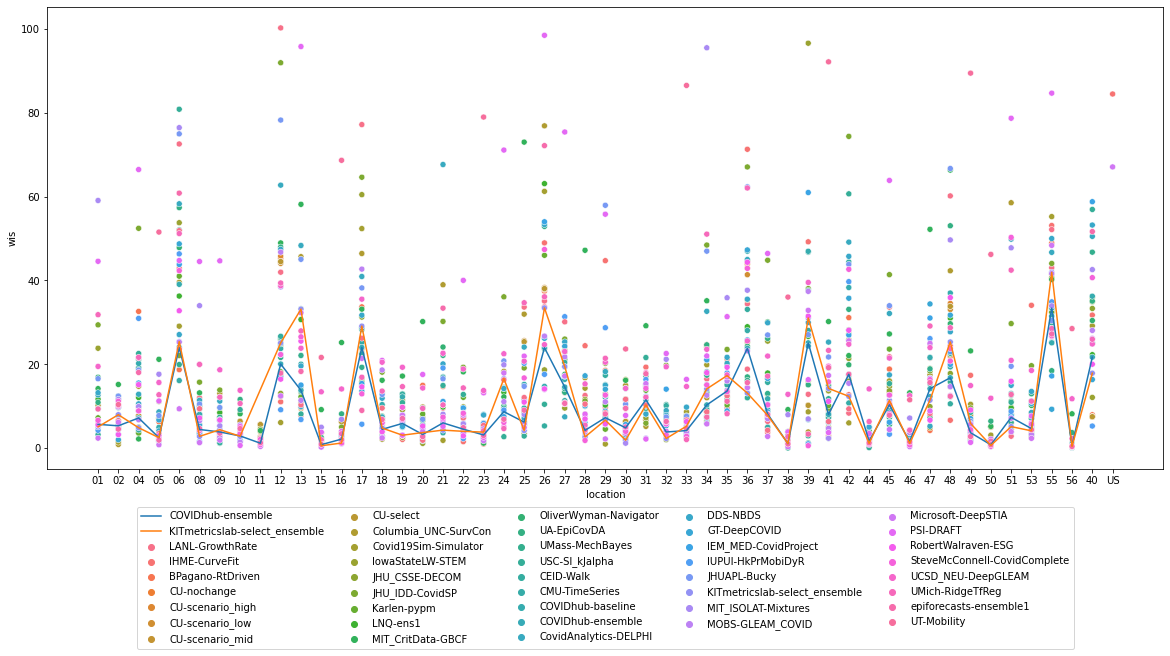

In [151]:
fig, ax = plt.subplots(figsize=(20, 8.5))
sb.scatterplot(data=scores, x='location', y='wis', hue='model', ax=ax)
sb.lineplot(data=scores[scores.model.isin(['KITmetricslab-select_ensemble', 'COVIDhub-ensemble'])], 
            x='location', y='wis', hue='model', ax=ax)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4), ncol=5)

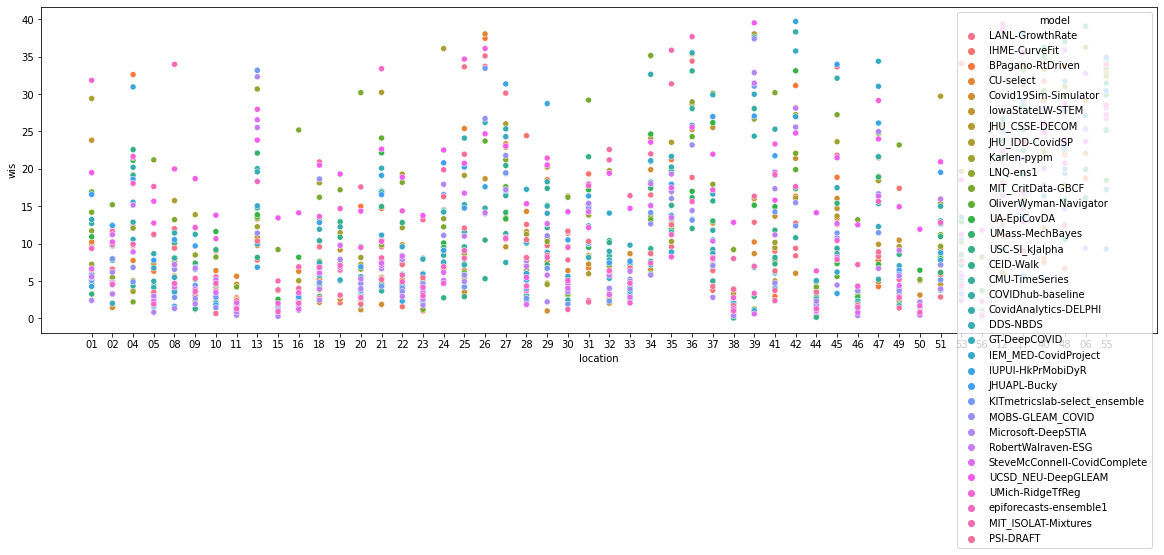

In [97]:
plt.figure(figsize=(20, 6))
g = sb.scatterplot(data=scores, x='location', y='wis', hue='model')

# Export

In [69]:
df.to_csv('data/ensemble_data/df_train_{}.csv'.format(str(test_date.date())), index=False)

In [70]:
df_test.to_csv('data/ensemble_data/df_test_{}.csv'.format(str(test_date.date())), index=False)